<a href="https://colab.research.google.com/github/arnaldojr/powerlinesegmentation/blob/main/mestrado_UNET_11_04_2023_dados_videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("ggplot")
plt.style.use("classic")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, array_to_img, load_img


import tensorflow as tf
import sys
import keras
import cv2
print(sys.version)
print("Versao de tensorflow:",tf.__version__)
print("Versao de Keras independente:",keras.__version__)
print("Versao de Keras dentro de tensorflow:",tf.keras.__version__)
print("Versao cv2:",cv2.__version__)
print()

gpu=tf.test.gpu_device_name()
if gpu=="":
  print("Computador sem GPU.")
else:
  print("Computador com GPU:",tf.test.gpu_device_name())
  from tensorflow.python.client import device_lib
  devices=device_lib.list_local_devices()
  print("Dispositivos:",[x.physical_device_desc for x in devices if x.physical_device_desc!=""])
print()

!lsb_release -a | grep "Description" #imprime qual é o sistema operacional
!echo

!cat /proc/cpuinfo | grep -E "model name|core" #especificações de CPU
!echo

!cat /proc/meminfo | grep "Mem" #especificações de RAM

!nvidia-smi
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Versao de tensorflow: 2.12.0
Versao de Keras independente: 2.12.0
Versao de Keras dentro de tensorflow: 2.12.0
Versao cv2: 4.7.0

Computador com GPU: /device:GPU:0
Dispositivos: ['device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5']

No LSB modules are available.
Description:	Ubuntu 20.04.5 LTS

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
core id		: 0
cpu cores	: 2
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
core id		: 1
cpu cores	: 2
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
core id		: 0
cpu cores	: 2
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
core id		: 1
cpu cores	: 2

MemTotal:       26690604 kB
MemFree:        20351896 kB
MemAvailable:   24246736 kB
Wed Apr 19 06:10:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------

### carrega o drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Carrega imagens

In [ ]:
##pega os nomes dasimagens


#ids = next(os.walk("/content/drive/MyDrive/pldu/images"))[2] # list of names all images in the given path
ids = next(os.walk("/content/drive/MyDrive/pldu_aug/train_img"))[2] # list of names all images in the given path
#ids = next(os.walk("/content/drive/MyDrive/pldu_arnaldo/train"))[2] # list of names all images in the given path

ids.sort()
print("No. de images = ", len(ids))


idsMasks = next(os.walk("/content/drive/MyDrive/pldu_aug/train_label"))[2] # list of names all images in the given path
#idsMasks = next(os.walk("/content/drive/MyDrive/pldu_arnaldo/train_gt"))[2] # list of names all images in the given path

idsMasks.sort()
print("No. de images = ", len(idsMasks))

In [ ]:
id = -1

print(ids[id],idsMasks[id])

In [ ]:
### ajuste tamanho da imagem para 256x256
im_width = 256
im_height = 256

In [ ]:
X_original = np.zeros((len(ids), im_height, im_width, 3), dtype=np.uint8)
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y_original = np.zeros((len(idsMasks), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(idsMasks), im_height, im_width, 1), dtype=np.float32)

In [ ]:
### carrega imagens da lista de ids

for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/MyDrive/pldu_arnaldo/train/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width, 3), mode = 'constant', preserve_range = True)

    # Save images
    X_original[n] = x_img



<ipython-input-9-1551d52a1718>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/1936 [00:00<?, ?it/s]

(1936, 256, 256, 3)


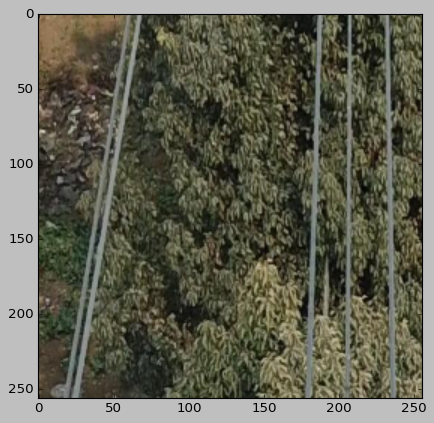

In [ ]:
print(X_original.shape)

plt.imshow(X_original[0])

In [ ]:
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/MyDrive/pldu_arnaldo/train/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)

    # Save images
    X[n] = x_img/255.0

<ipython-input-13-cf52f2b18ef4>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/1936 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


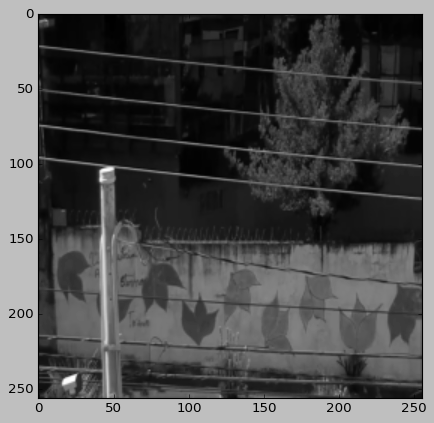

In [ ]:
plt.imshow(X[555],cmap="gray")

In [ ]:
kernel = np.ones((5,5),np.uint8)
for n, id_ in tqdm_notebook(enumerate(idsMasks), total=len(ids)):
    # Load masks
    mask_orig = load_img("/content/drive/MyDrive/pldu_arnaldo/train_gt/"+id_, grayscale=True)

    mask = img_to_array(mask_orig)
    #print(mask.max())
    y_original[n] = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)

   # mask = cv2.dilate(mask,kernel,iterations = 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CROSS, kernel)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #_,mask = cv2.threshold(mask,120,255,cv2.THRESH_BINARY)


    mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Save images
    y[n] = mask/255.0

<ipython-input-15-c6c81b76dd0e>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(idsMasks), total=len(ids)):


  0%|          | 0/1936 [00:00<?, ?it/s]

(1936, 256, 256, 1)


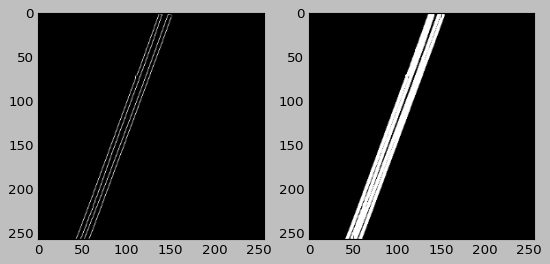

In [ ]:
print(y.shape)
n = 1
plt.subplot(1,2,1)
plt.imshow(y_original[n],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y[n],cmap='gray')


#### Load the images and masks into arrays

In [ ]:
idstest = next(os.walk("/content/drive/MyDrive/pldu_arnaldo/test"))[2] # list of names all images in the given path
idstest.sort()
print("No. of images = ", len(idstest))

X_valid_original = np.zeros((len(idstest), im_height, im_width, 3), dtype=np.uint8)
X_valid = np.zeros((len(idstest), im_height, im_width, 1), dtype=np.float32)

for n, id_ in tqdm_notebook(enumerate(idstest), total=len(idstest)):
    # Load images
    img = load_img("/content/drive/MyDrive/pldu_arnaldo/test/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width, 3), mode = 'constant', preserve_range = True)

    # Save images
    X_valid_original[n] = x_img

for n, id_ in tqdm_notebook(enumerate(idstest), total=len(idstest)):
    # Load images
    imgtest = load_img("/content/drive/MyDrive/pldu_arnaldo/test/"+id_, grayscale=True)
    x_imgtest = img_to_array(imgtest)
    x_imgtest = resize(x_imgtest, (im_height, im_width, 1), mode = 'constant', preserve_range = True)

    # Save images
    X_valid[n] = x_imgtest/255.0

No. of images =  120


<ipython-input-17-6cd2913b117c>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(idstest), total=len(idstest)):


  0%|          | 0/120 [00:00<?, ?it/s]

<ipython-input-17-6cd2913b117c>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(idstest), total=len(idstest)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
kernel = np.ones((5,5),np.uint8)

idsMaskstest = next(os.walk("/content/drive/MyDrive/pldu_arnaldo/test_gt"))[2] # list of names all images in the given path
idsMaskstest.sort()
print("No. of images = ", len(idsMaskstest))

y_valid = np.zeros((len(idsMaskstest), im_height, im_width, 1), dtype=np.float32)
y_originaltest = np.zeros((len(idsMaskstest), im_height, im_width, 1), dtype=np.float32)


for n, id_ in tqdm_notebook(enumerate(idsMaskstest), total=len(idsMaskstest)):
    # Load masks
    mask_origtest = load_img("/content/drive/MyDrive/pldu_arnaldo/test_gt/"+id_, grayscale=True)

    masktest = img_to_array(mask_origtest)
    #print(mask.max())
    y_originaltest[n] = resize(masktest, (im_height, im_width, 1), mode = 'constant', preserve_range = True)

   # mask = cv2.dilate(mask,kernel,iterations = 1)
    masktest = cv2.morphologyEx(masktest, cv2.MORPH_CROSS, kernel)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #_,mask = cv2.threshold(mask,120,255,cv2.THRESH_BINARY)


    masktest = resize(masktest, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Save images
    y_valid[n] = masktest/255.0

No. of images =  120


<ipython-input-18-c257a07f6683>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(idsMaskstest), total=len(idsMaskstest)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
# Split train and valid
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
print(ids[0],idsMasks[0])
X_train = X
y_train = y

print("X_train: {0}, X_validation: {1}".format(X_train.shape,X_valid.shape))
print("y_train: {0}, y_validation: {1}".format(y_train.shape,y_valid.shape))


img_000000.jpg img_000000.png
X_train: (1936, 256, 256, 1), X_validation: (120, 256, 256, 1)
y_train: (1936, 256, 256, 1), y_validation: (120, 256, 256, 1)


#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Mask')

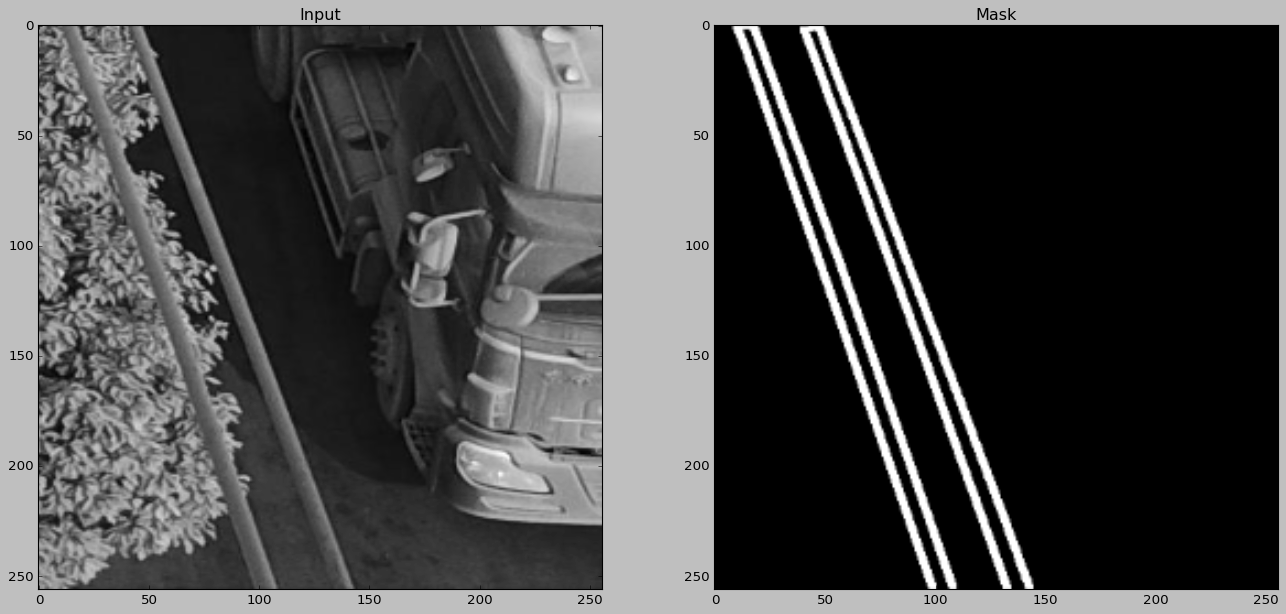

In [ ]:
ix = 15

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix],cmap='gray', interpolation = 'bilinear')
ax1.set_title('Input')

ax2.imshow(y_train[ix].squeeze(),cmap='gray')
ax2.set_title('Mask')


Aplicando o data augmentation



In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# seed = 42
# BATCH_SIZE = 32

# # Creating the training Image and Mask generator
# image_datagen = ImageDataGenerator(shear_range=0.5, \
#                                          rotation_range=50, \
#                                          zoom_range=0.2,\
#                                          width_shift_range=0.2, \
#                                          height_shift_range=0.2,\
#                                          fill_mode='reflect')
# mask_datagen = ImageDataGenerator(shear_range=0.5,\
#                                         rotation_range=50, \
#                                         zoom_range=0.2,\
#                                         width_shift_range=0.2,\
#                                         height_shift_range=0.2, \
#                                         fill_mode='reflect')

# # Keep the same seed for image and mask generators so they fit together

# image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
# mask_datagen.fit(y_train[:int(y_train.shape[0]*0.9)], augment=True, seed=seed)

# x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],\
#                      batch_size=BATCH_SIZE,\
#                      shuffle=True,\
#                      seed=seed)
# y=mask_datagen.flow(y_train[:int(y_train.shape[0]*0.9)],\
#                     batch_size=BATCH_SIZE,\
#                     shuffle=True, \
#                     seed=seed)



# Creating the validation Image and Mask generator
#image_datagen_val = image.ImageDataGenerator()
#mask_datagen_val = image.ImageDataGenerator()

#image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
#mask_datagen_val.fit(y_train[int(y_train.shape[0]*0.9):], augment=True, seed=seed)

#x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
#y_val=mask_datagen_val.flow(y_train[int(y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [ ]:
# ############3 tentativa 2
# from keras.preprocessing.image import ImageDataGenerator

# seed = 42
# BATCH_SIZE = 32

# data_gen_args = dict(featurewise_center=False,
#                      featurewise_std_normalization=False,
#                      rotation_range=0.2,
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.2,
#                      horizontal_flip=True,
#                      fill_mode = 'constant',
#                      shear_range = 0.5)

# image_datagen = ImageDataGenerator(**data_gen_args)#data generator works on both image and masks
# mask_datagen = ImageDataGenerator(**data_gen_args)


# image_datagen.fit(X_train, augment=True, seed=seed)
# mask_datagen.fit(y_train, augment=True, seed=seed)

# image_generator=image_datagen.flow(X_train,
#                                    batch_size = BATCH_SIZE,
#                                    shuffle = True,
#                                    seed = seed)

# mask_generator=mask_datagen.flow(y_train,
#                                  batch_size = BATCH_SIZE,
#                                  shuffle = True,
#                                  seed = seed)

# train_generator = zip(image_generator, mask_generator)


In [ ]:
# total_images = image_generator.n // image_generator.batch_size * image_generator.batch_size
# print(total_images)

512


In [ ]:
# import matplotlib.pyplot as plt

# # Itera 10 vezes para plotar as 10 primeiras imagens e máscaras geradas
# for i in range(100):
#     # Obtém o próximo lote de imagens e máscaras
#     images, masks = next(train_generator)
#     print(len(images))
#     # Plota as primeiras 5 imagens do lote
#     for j in range(32):
#         plt.subplot(1, 32, j+1)
#         plt.imshow(images[j], cmap='gray')
#         plt.axis('off')
#         plt.subplot(2, 32, 32+j+1)
#         plt.imshow(masks[j], cmap='gray')
#         plt.axis('off')

#     # Exibe os plots das imagens e máscaras
#     plt.show()


## carregamento da arquitetura da rede

In [ ]:
from keras.losses import binary_crossentropy
from keras import backend as K
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])

    model.compile(optimizer = Adam(), loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)






In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
for layer in model.layers:
    print(layer.input_shape, layer.output_shape)


[(None, 256, 256, 1)] [(None, 256, 256, 1)]
(None, 256, 256, 1) (None, 256, 256, 16)
(None, 256, 256, 16) (None, 256, 256, 16)
(None, 256, 256, 16) (None, 256, 256, 16)
(None, 256, 256, 16) (None, 128, 128, 16)
(None, 128, 128, 16) (None, 128, 128, 16)
(None, 128, 128, 16) (None, 128, 128, 32)
(None, 128, 128, 32) (None, 128, 128, 32)
(None, 128, 128, 32) (None, 128, 128, 32)
(None, 128, 128, 32) (None, 64, 64, 32)
(None, 64, 64, 32) (None, 64, 64, 32)
(None, 64, 64, 32) (None, 64, 64, 64)
(None, 64, 64, 64) (None, 64, 64, 64)
(None, 64, 64, 64) (None, 64, 64, 64)
(None, 64, 64, 64) (None, 32, 32, 64)
(None, 32, 32, 64) (None, 32, 32, 64)
(None, 32, 32, 64) (None, 32, 32, 128)
(None, 32, 32, 128) (None, 32, 32, 128)
(None, 32, 32, 128) (None, 32, 32, 128)
(None, 32, 32, 128) (None, 16, 16, 128)
(None, 16, 16, 128) (None, 16, 16, 128)
(None, 16, 16, 128) (None, 16, 16, 256)
(None, 16, 16, 256) (None, 16, 16, 256)
(None, 16, 16, 256) (None, 16, 16, 256)
(None, 16, 16, 256) (None, 32, 32,

In [ ]:
#### carrega os pessos da rede já treinada

tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)


In [ ]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('mestrado-UNET-13-04-23.h5', verbose=1, save_best_only=True, save_weights_only=False),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]


In [ ]:
#####para testar

### posso criar valid_generator
# model.fit_generator(train_generator, \
#                    steps_per_epoch=200, \
#                    epochs=40, \
#                    validation_data = valid_generator,\
#                    validation_steps=50, \
#                    verbose = 1, \
#                    callbacks=callbacks)


# results = model.fit(train_generator, \
#                     steps_per_epoch=200, \
#                     epochs=40, \
#                     validation_data = (X_valid, y_valid),\
#                     validation_steps=50, \
#                     verbose = 1, \
#                     callbacks=callbacks)

###pode ser que de certo isso aqui......
ressults = model.fit(X_train, y_train,\
                    batch_size=12, \
                    epochs=20, \
                    verbose=1,\
                    validation_split=0.2, \
                    shuffle=True, \
                    callbacks=callbacks)



Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.7530
Epoch 1: val_loss improved from inf to 0.34455, saving model to mestrado-UNET-13-04-23.h5
129/129 [==============================] - 31s 138ms/step - loss: 0.4147 - accuracy: 0.7530 - val_loss: 0.3445 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 2/20
129/129 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.8040
Epoch 2: val_loss improved from 0.34455 to 0.13698, saving model to mestrado-UNET-13-04-23.h5
129/129 [==============================] - 16s 126ms/step - loss: 0.2296 - accuracy: 0.8040 - val_loss: 0.1370 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 3/20
129/129 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.8057
Epoch 3: val_loss improved from 0.13698 to 0.12556, saving model to mestrado-UNET-13-04-23.h5
129/129 [==============================] - 16s 125ms/step - loss: 0.1774 - accuracy: 0.8057 - val_loss: 0.1256 - val_accuracy: 0.8385 - lr: 

In [ ]:
# ### esse eu sei que roda legal.....
# results = model.fit(X_train, y_train,\
#                     batch_size=12, \
#                     epochs=500, \
#                     callbacks=callbacks,\
#                     validation_data=(X_valid, y_valid))

# results = model.fit(train_generator,\
#                     steps_per_epoch=2000,\
#                     batch_size=32, \
#                     epochs=200, \
#                     callbacks=callbacks,\
#                     validation_data=(X_valid, y_valid))


#results = model.fit(trainGenerator(), batch_size=32, epochs=500, callbacks=callbacks,\
#                    validation_data=(X_valid, y_valid))


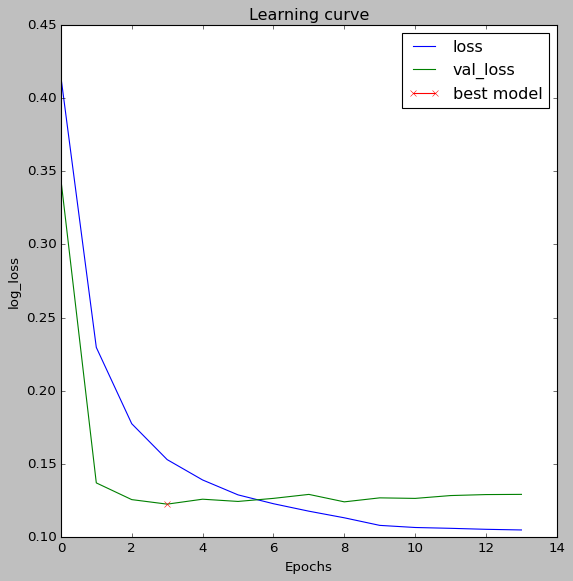

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(ressults.history["loss"], label="loss")
plt.plot(ressults.history["val_loss"], label="val_loss")
plt.plot( np.argmin(ressults.history["val_loss"]), np.min(ressults.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

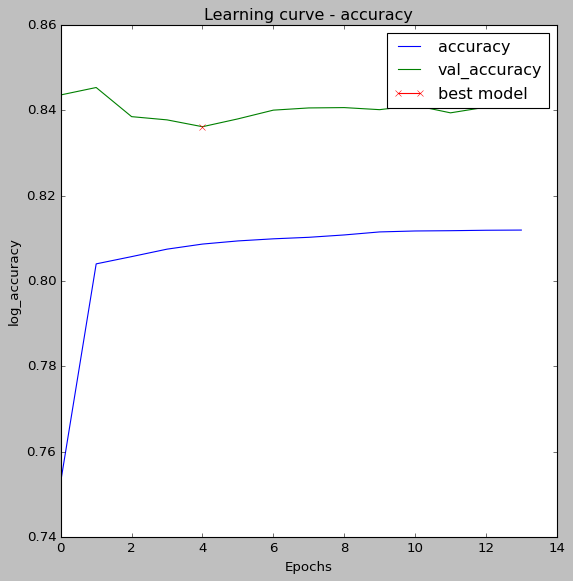

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - accuracy")
plt.plot(ressults.history["accuracy"], label="accuracy")
plt.plot(ressults.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(ressults.history["val_accuracy"]), np.min(ressults.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend();



### Inference

In [ ]:
# load the best model
###model.load_weights('model-tgs-salt.h5')

In [ ]:
### salvar modelo

model.save('/content/drive/MyDrive/my_model-13-04-23.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

4/4 [==============================] - 4s 650ms/step - loss: 2.6068 - accuracy: 0.0000e+00


[2.606786012649536, 0.0]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

4/4 [==============================] - 0s 61ms/step


In [ ]:


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None, save_dir="/content/drive/MyDrive/samples"):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

  #  has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))

    ax[0].imshow(X[ix])
    ax[0].set_title('Entrada')
    ax[0].axis("off")

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Referência')
    ax[1].axis("off")

#    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
#    ax[2].set_title('Predicted')

    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    ax[2].set_title('Predição')
    ax[2].axis("off")

    # Verifica se o diretório de salvamento existe, caso contrário, cria o diretório
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Define o nome do arquivo com base no valor de ix
    file_name = f"sample_{ix}.png"
    save_path = os.path.join(save_dir, file_name)

    # Salva a figura no arquivo especificado
    #plt.savefig(save_path)

    #plt.close()  # Fecha a figura para liberar memória

    plt.show()



### Predictions on training set

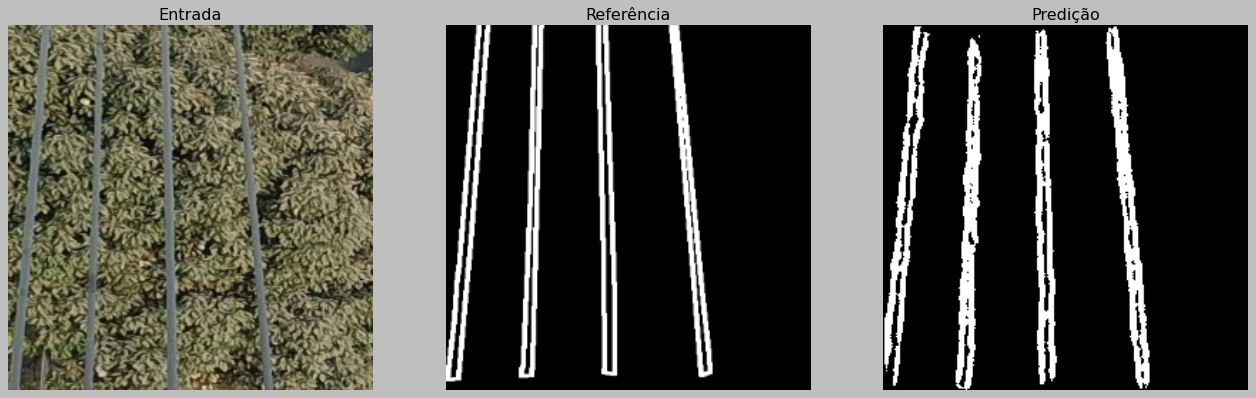

In [ ]:
# Check if training data looks all right

plot_sample(X_original, y_train, preds_train, preds_train_t, ix=3)

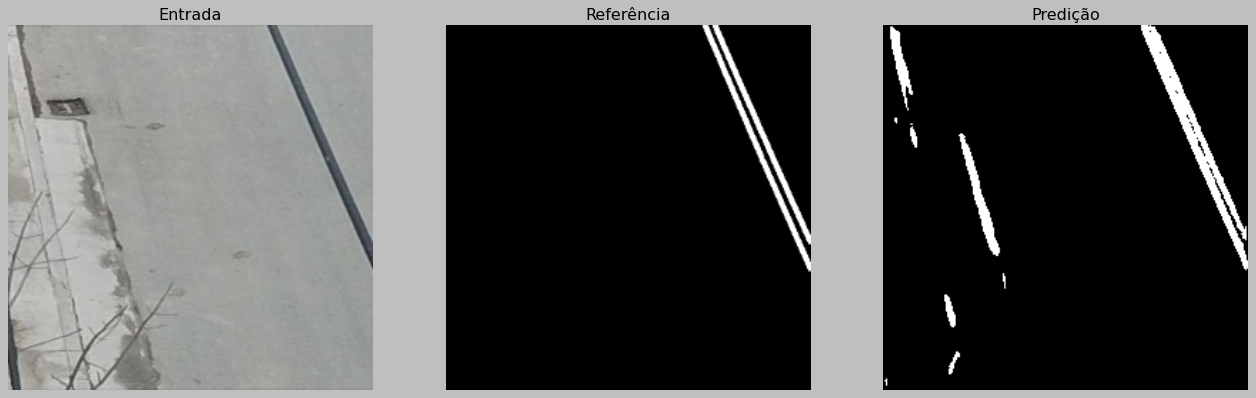

In [ ]:
plot_sample(X_original, y_train, preds_train, preds_train_t)

### Predictions on test set

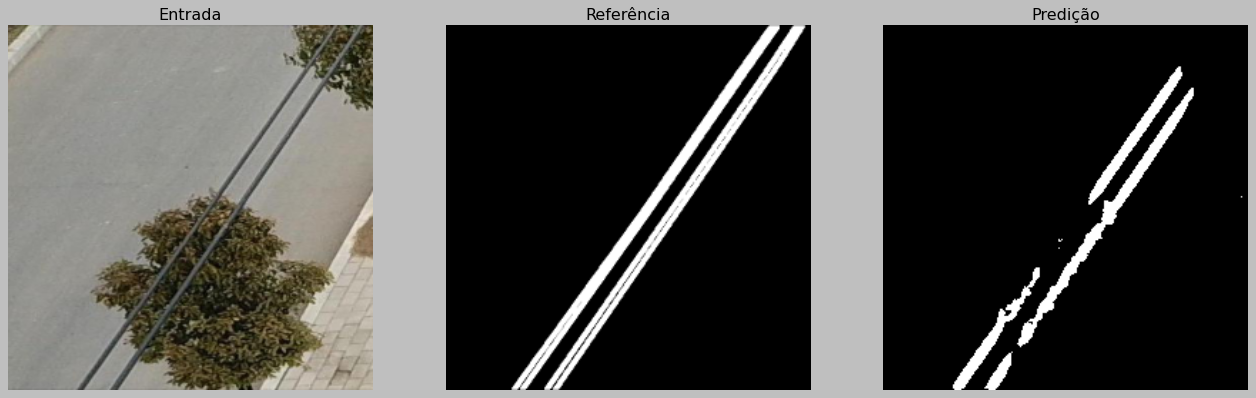

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid_original, y_valid, preds_val, preds_val_t, ix=19)

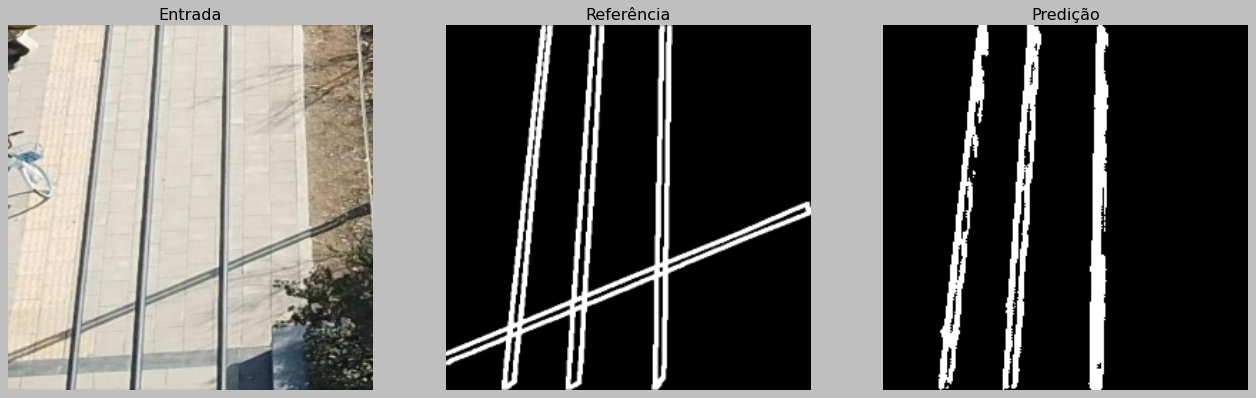

In [ ]:
plot_sample(X_valid_original, y_valid, preds_val, preds_val_t)

Metricas de performance


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np


def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return intersection/union

a = iou(y_valid, preds_val)
print(a)

tf.Tensor(0.082811885, shape=(), dtype=float32)


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

res = dice_coef(y_valid, preds_val)
print(res)



tf.Tensor(0.1529573, shape=(), dtype=float32)


# teste transfer learning

## Backbone VGG16 + UNET


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import get_file

def build_unet_vgg16(input_shape, num_classes, weights='imagenet'):
    input_layer = Input(shape=input_shape)

    # Repetindo o canal de escala de cinza 3 vezes para criar uma imagem RGB
    grayscale_to_rgb = tf.tile(input_layer, [1, 1, 1, 3])

    # Carregando a VGG16 com os pesos da ImageNet

    vgg16 = VGG16(weights=weights, include_top=False, input_tensor=grayscale_to_rgb)


    # Extraindo os recursos das camadas da VGG16
    block1_conv2 = vgg16.get_layer('block1_conv2').output
    block2_conv2 = vgg16.get_layer('block2_conv2').output
    block3_conv3 = vgg16.get_layer('block3_conv3').output
    block4_conv3 = vgg16.get_layer('block4_conv3').output
    block5_conv3 = vgg16.get_layer('block5_conv3').output

    # U-Net
    up6 = concatenate([UpSampling2D(size=(2, 2))(block5_conv3), block4_conv3])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), block3_conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), block2_conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), block1_conv2])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=input_layer, outputs=conv10)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    return model

In [ ]:
# Exemplo de uso
input_shape = (256, 256, 1)
num_classes = 1 # Número de classes de segmentação binária

model = build_unet_vgg16(input_shape, num_classes)
#model.summary()

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('mestrado-UNET-13-04-23-vggunet.h5', verbose=1, save_best_only=True, save_weights_only=False),
    CSVLogger("dataResUnet-vggunet.csv"),
    TensorBoard(log_dir='./logs')
]




ressults = model.fit(X_train, y_train,\
                    batch_size=12, \
                    epochs=20, \
                    verbose=1,\
                    validation_split=0.2, \
                    shuffle=True, \
                    callbacks=callbacks)

Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.7968
Epoch 1: val_loss improved from inf to 0.16122, saving model to mestrado-UNET-13-04-23-vggunet.h5
129/129 [==============================] - 117s 703ms/step - loss: 0.3495 - accuracy: 0.7968 - val_loss: 0.1612 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 2/20
129/129 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.8038
Epoch 2: val_loss did not improve from 0.16122
129/129 [==============================] - 87s 675ms/step - loss: 0.1909 - accuracy: 0.8038 - val_loss: 0.1768 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 3/20
129/129 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.8048
Epoch 3: val_loss did not improve from 0.16122
129/129 [==============================] - 87s 674ms/step - loss: 0.1861 - accuracy: 0.8048 - val_loss: 0.2008 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 4/20
129/129 [==============================] - ETA: 0s - loss: 0.1953 -

In [ ]:
model.save('my_model-13-04-23-vggunet.h5')
model.save('/content/drive/MyDrive/my_model-13-04-23-vggunet.h5')

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

4/4 [==============================] - 12s 4s/step


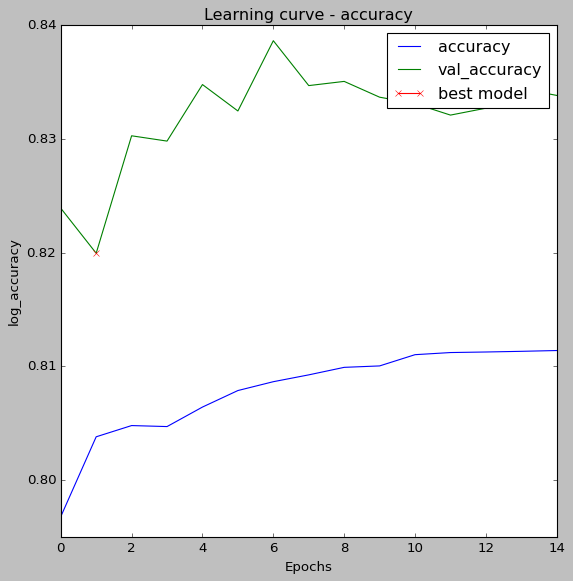

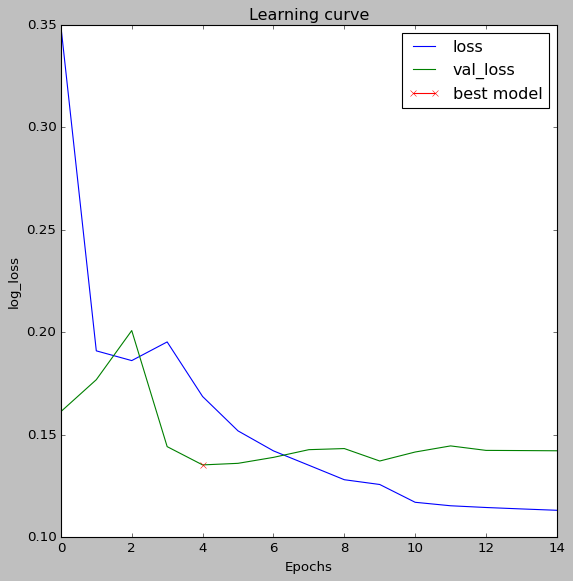

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - accuracy")
plt.plot(ressults.history["accuracy"], label="accuracy")
plt.plot(ressults.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(ressults.history["val_accuracy"]), np.min(ressults.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(ressults.history["loss"], label="loss")
plt.plot(ressults.history["val_loss"], label="val_loss")
plt.plot( np.argmin(ressults.history["val_loss"]), np.min(ressults.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

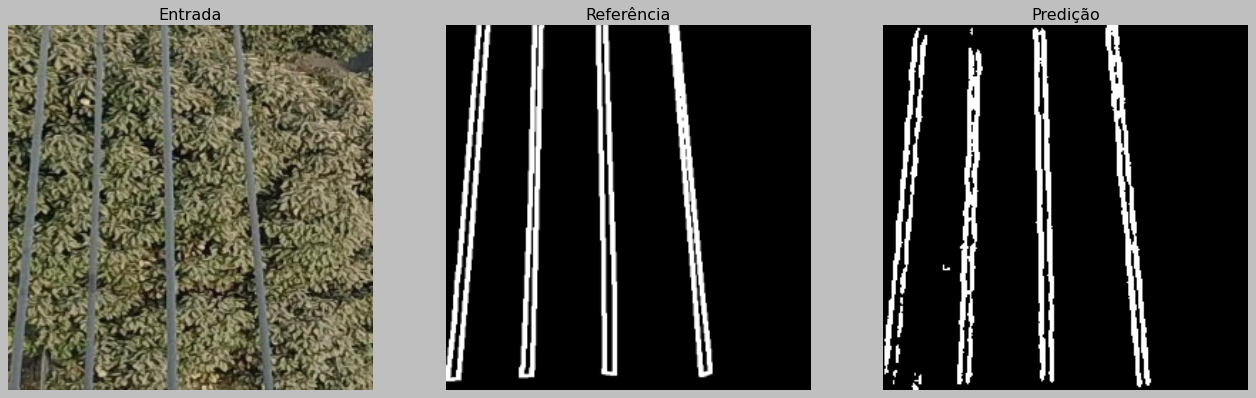

In [ ]:
# predição dados treino
plot_sample(X_original, y_train, preds_train, preds_train_t, ix=3)

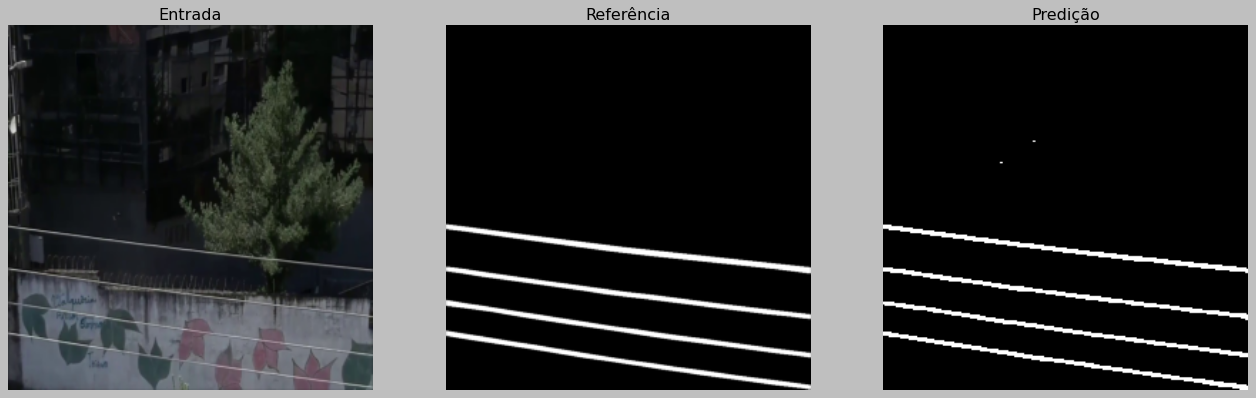

In [ ]:
plot_sample(X_original, y_train, preds_train, preds_train_t)

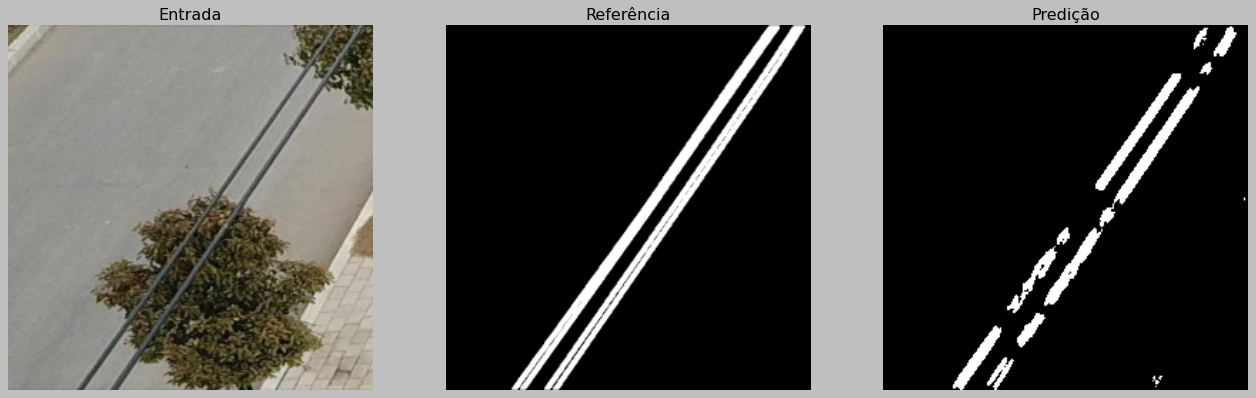

In [ ]:
# predição dados validação
plot_sample(X_valid_original, y_valid, preds_val, preds_val_t, ix=19)

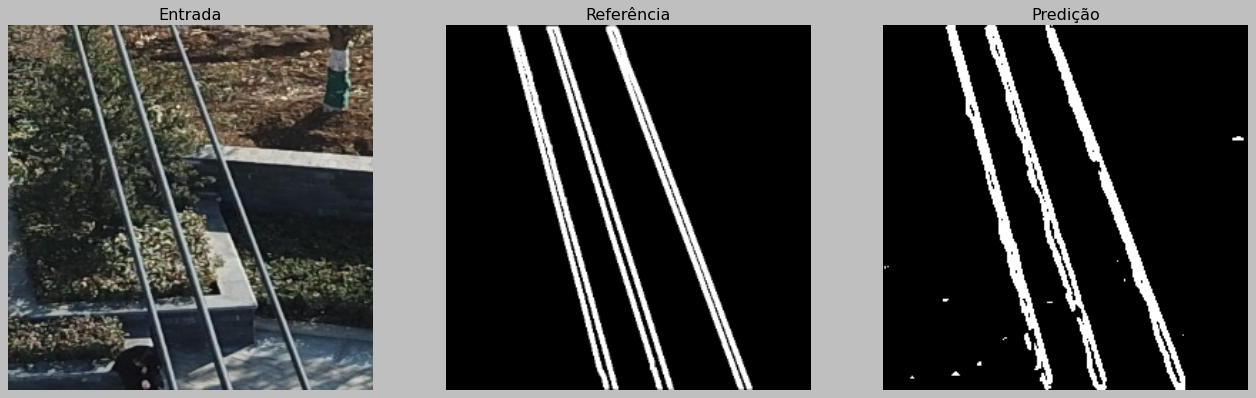

In [ ]:
plot_sample(X_valid_original, y_valid, preds_val, preds_val_t)

## backbone resnet50 + unet

In [ ]:
from tensorflow.keras.applications import ResNet50

def build_unet_resnet50(input_shape, num_classes, weights='imagenet'):
    input_layer = Input(shape=input_shape)

        # Repetindo o canal de escala de cinza 3 vezes para criar uma imagem RGB
    grayscale_to_rgb = tf.tile(input_layer, [1, 1, 1, 3])
    resnet50 = ResNet50(weights=weights, include_top=False, input_tensor=grayscale_to_rgb)
    # Carregando a ResNet-50 com os pesos da ImageNet
    #resnet50 = ResNet50(weights=weights, include_top=False, input_tensor=input_layer)

    # Extraindo os recursos das camadas da ResNet-50
    conv1 = resnet50.get_layer('conv1_relu').output
    conv2_x = resnet50.get_layer('conv2_block3_out').output
    conv3_x = resnet50.get_layer('conv3_block4_out').output
    conv4_x = resnet50.get_layer('conv4_block6_out').output
    conv5_x = resnet50.get_layer('conv5_block3_out').output

    # U-Net
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5_x), conv4_x])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3_x])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2_x])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    up10 = UpSampling2D(size=(2, 2))(conv9) # Adicione esta linha
    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(up10)

    model = Model(inputs=input_layer, outputs=conv10)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model




In [ ]:
# Exemplo de uso
input_shape = (256, 256, 1)
num_classes = 1 # Número de classes de segmentação binária

model = build_unet_resnet50(input_shape, num_classes)
#model.summary()


callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('mestrado-UNET-13-04-23-ResNet50.h5', verbose=1, save_best_only=True, save_weights_only=False),
    CSVLogger("dataResUnet-ResNet50.csv"),
    TensorBoard(log_dir='./logs')
]




ressults = model.fit(X_train, y_train,\
                    batch_size=12, \
                    epochs=20, \
                    verbose=1,\
                    validation_split=0.2, \
                    shuffle=True, \
                    callbacks=callbacks)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.0086
Epoch 1: val_loss improved from inf to 0.13997, saving model to mestrado-UNET-13-04-23-ResNet50.h5
129/129 [==============================] - 97s 377ms/step - loss: 0.3899 - accuracy: 0.0086 - val_loss: 0.1400 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
129/129 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.0086
Epoch 2: val_loss did not improve from 0.13997
129/129 [==============================] - 42s 328ms/step - loss: 0.1418 - accuracy: 0.0086 - val_loss: 0.1897 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/20
129/129 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.0086
Epoch 3: val_loss did not improve from 0.13997
129/129 [==============================] - 42s 330ms/step - loss: 0.1291 - accuracy: 0.0086 - val_loss: 0.2500 - val_accuracy: 0.0000e+00 - lr: 0.0010
E

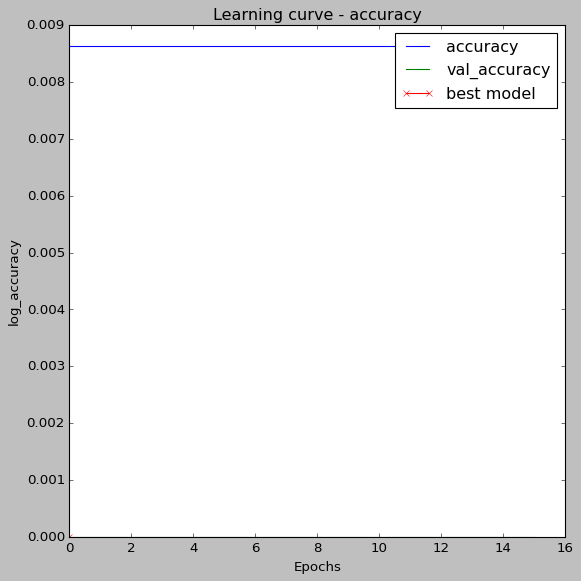

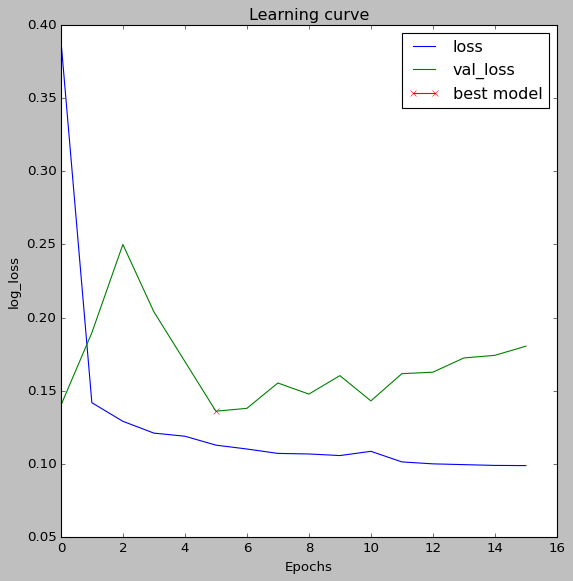

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - accuracy")
plt.plot(ressults.history["accuracy"], label="accuracy")
plt.plot(ressults.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(ressults.history["val_accuracy"]), np.min(ressults.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(ressults.history["loss"], label="loss")
plt.plot(ressults.history["val_loss"], label="val_loss")
plt.plot( np.argmin(ressults.history["val_loss"]), np.min(ressults.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
model.save('my_model-13-04-23-ResNet50.h5')
model.save('/content/drive/MyDrive/my_model-13-04-23-ResNet50.h5')

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

4/4 [==============================] - 5s 2s/step


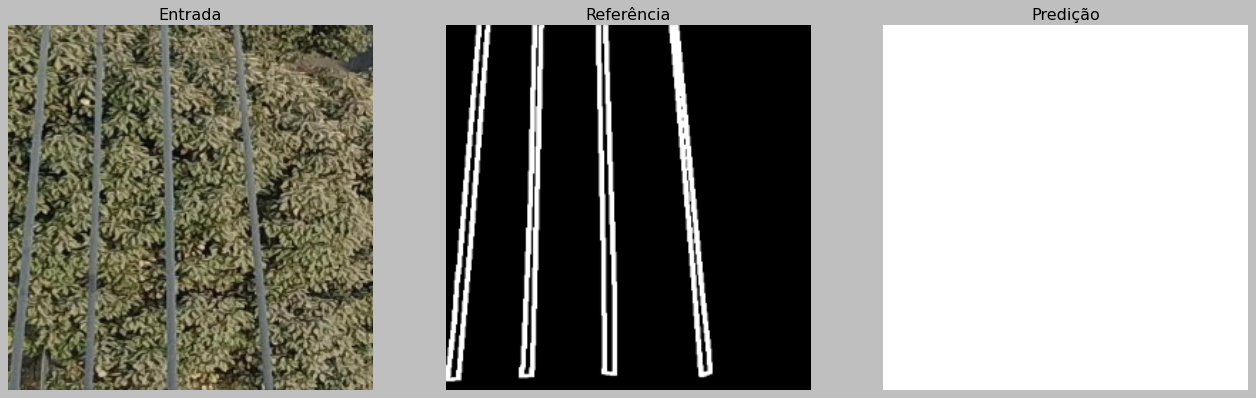

In [ ]:
# predição dados treino
plot_sample(X_original, y_train, preds_train, preds_train_t, ix=3)

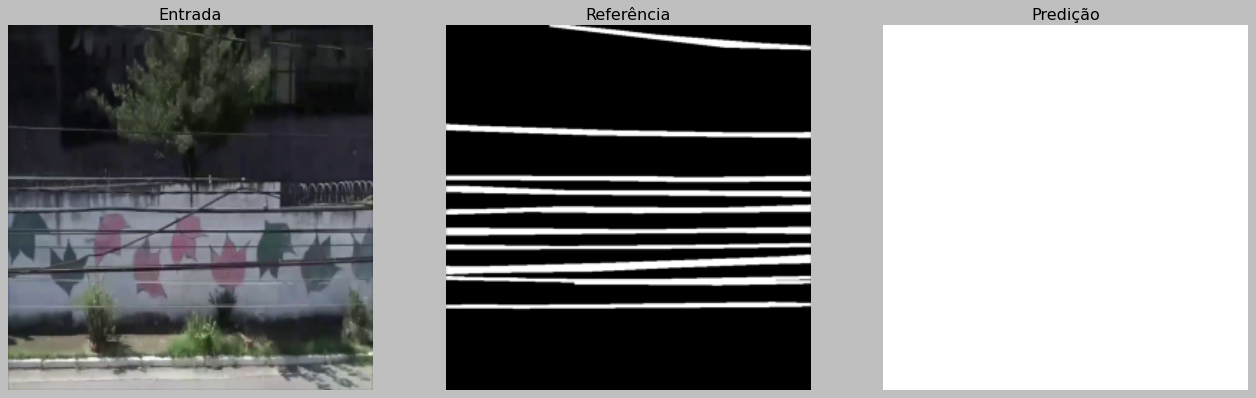

In [ ]:
# predição dados treino
plot_sample(X_original, y_train, preds_train, preds_train_t)

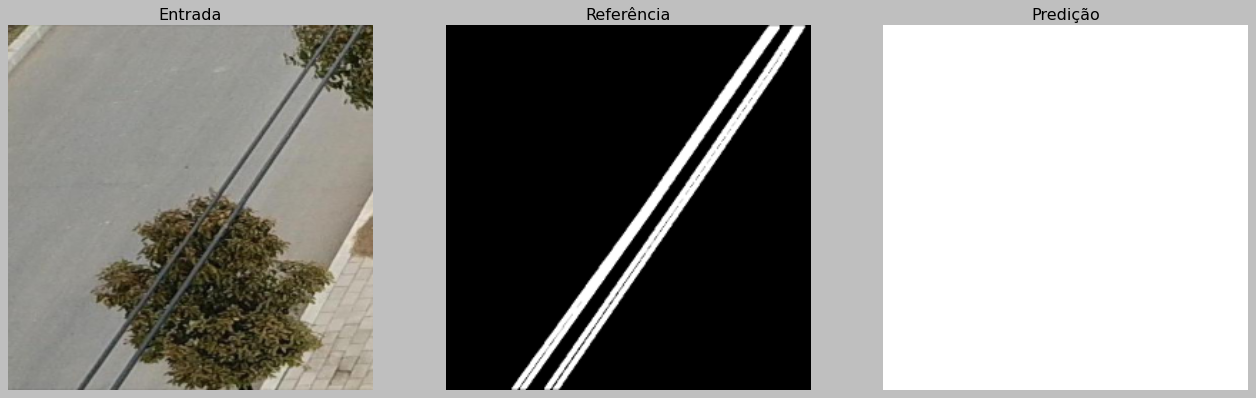

In [ ]:
# predição dados validação
plot_sample(X_valid_original, y_valid, preds_val, preds_val_t, ix=19)

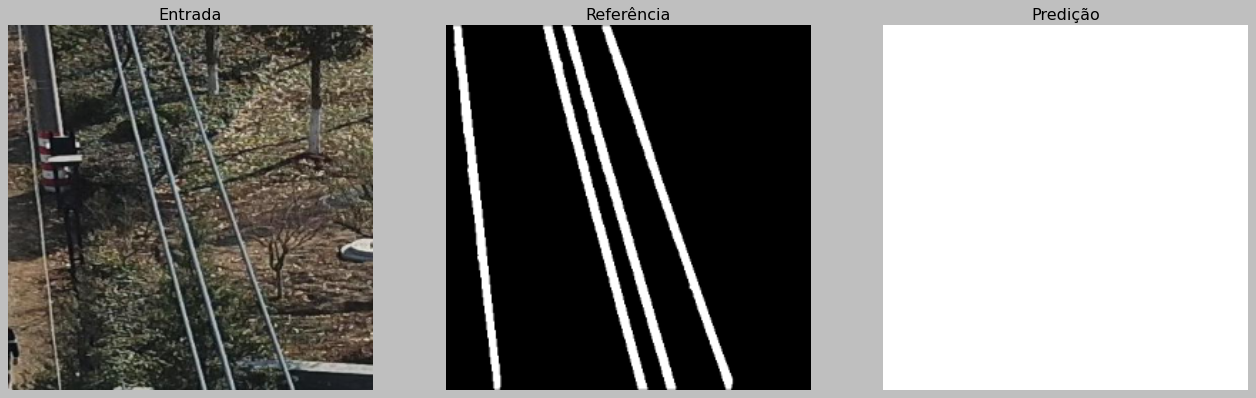

In [ ]:
plot_sample(X_valid_original, y_valid, preds_val, preds_val_t)

## backbone mobilenet + unet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

def build_unet_mobilenetv2(input_shape, num_classes, weights='imagenet'):
    input_layer = Input(shape=input_shape)

    # Repetindo o canal de escala de cinza 3 vezes para criar uma imagem RGB
    grayscale_to_rgb = tf.tile(input_layer, [1, 1, 1, 3])
    mobilenetv2 = MobileNetV2(weights=weights, include_top=False, input_tensor=grayscale_to_rgb)

    # Extraindo os recursos das camadas do MobileNetV2
    block1 = mobilenetv2.get_layer('block_1_expand_relu').output
    block2 = mobilenetv2.get_layer('block_3_expand_relu').output
    block3 = mobilenetv2.get_layer('block_6_expand_relu').output
    block4 = mobilenetv2.get_layer('block_13_expand_relu').output
    block5 = mobilenetv2.get_layer('block_16_expand_relu').output

    # U-Net
    up6 = concatenate([UpSampling2D(size=(2, 2))(block5), block4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), block3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), block2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), block1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    up10 = UpSampling2D(size=(2, 2))(conv9)
    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(up10)

    model = Model(inputs=input_layer, outputs=conv10)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model



In [ ]:
# Exemplo de uso
input_shape = (256, 256, 1)
num_classes = 1 # Número de classes de segmentação binária

model = build_unet_mobilenetv2(input_shape, num_classes)
#model.summary()


callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('mestrado-UNET-13-04-23-ResNet50.h5', verbose=1, save_best_only=True, save_weights_only=False),
    CSVLogger("dataResUnet-ResNet50.csv"),
    TensorBoard(log_dir='./logs')
]




ressults = model.fit(X_train, y_train,\
                    batch_size=12, \
                    epochs=20, \
                    verbose=1,\
                    validation_split=0.2, \
                    shuffle=True, \
                    callbacks=callbacks)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.7987
Epoch 1: val_loss improved from inf to 0.13248, saving model to mestrado-UNET-13-04-23-ResNet50.h5
129/129 [==============================] - 65s 226ms/step - loss: 0.2823 - accuracy: 0.7987 - val_loss: 0.1325 - val_accuracy: 0.8455 - lr: 0.0010
Epoch 2/20
129/129 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.8087
Epoch 2: val_loss improved from 0.13248 to 0.12712, saving model to mestrado-UNET-13-04-23-ResNet50.h5
129/129 [==============================] - 27s 207ms/step - loss: 0.1450 - accuracy: 0.8087 - val_loss: 0.1271 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 3/20
129/129 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.8102
Epoch 3: val_loss did not improve from 0.12712
129/129 [==============================] - 26s 199ms/step - loss: 0.1288 - accuracy: 0.8102 - val_loss: 0.

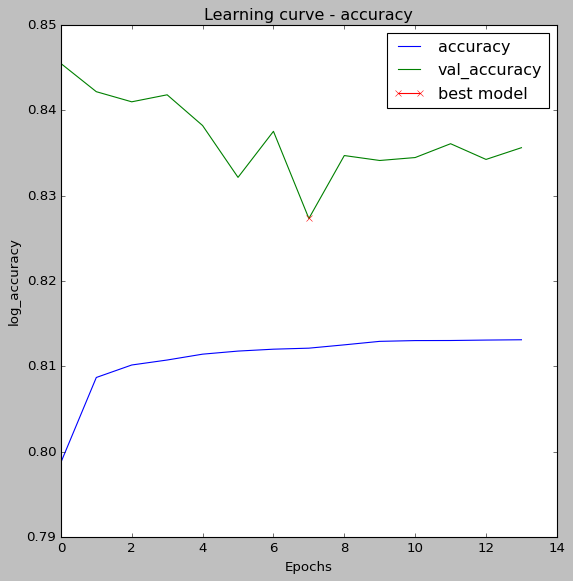

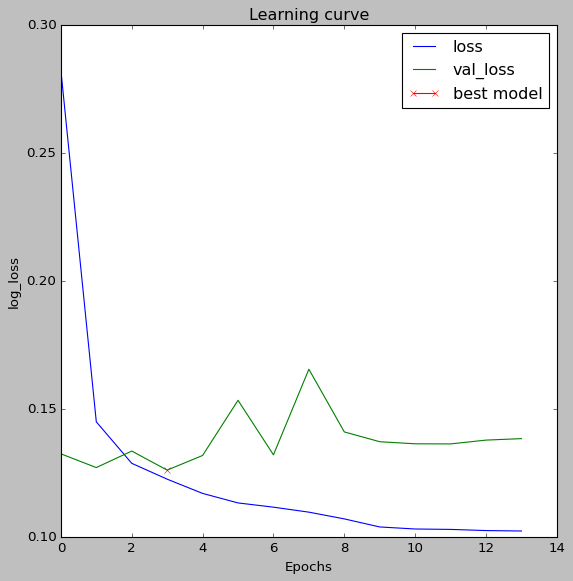

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve - accuracy")
plt.plot(ressults.history["accuracy"], label="accuracy")
plt.plot(ressults.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(ressults.history["val_accuracy"]), np.min(ressults.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(ressults.history["loss"], label="loss")
plt.plot(ressults.history["val_loss"], label="val_loss")
plt.plot( np.argmin(ressults.history["val_loss"]), np.min(ressults.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
model.save('my_model-13-04-23-mobilenet.h5')
model.save('/content/drive/MyDrive/my_model-13-04-23-mobilenet.h5')

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

4/4 [==============================] - 3s 1s/step


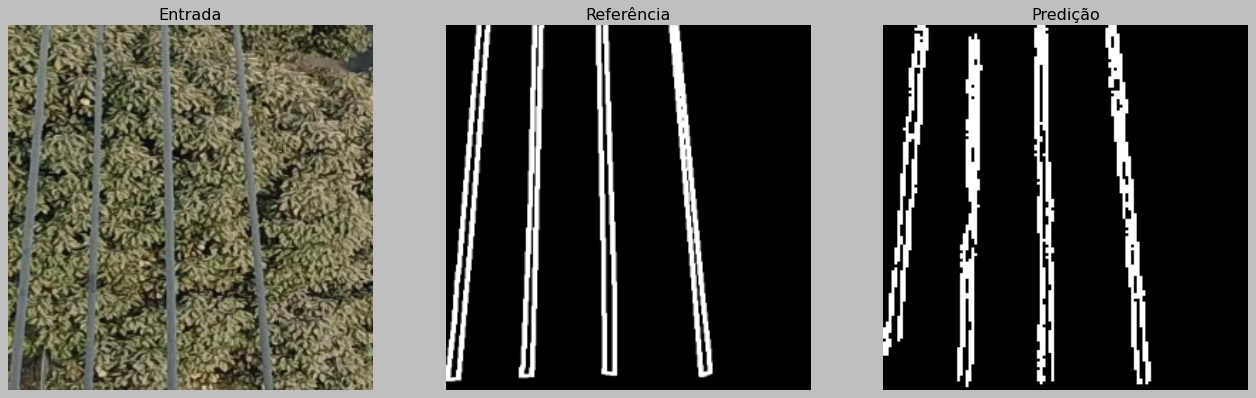

In [ ]:
# predição dados treino
plot_sample(X_original, y_train, preds_train, preds_train_t, ix=3)

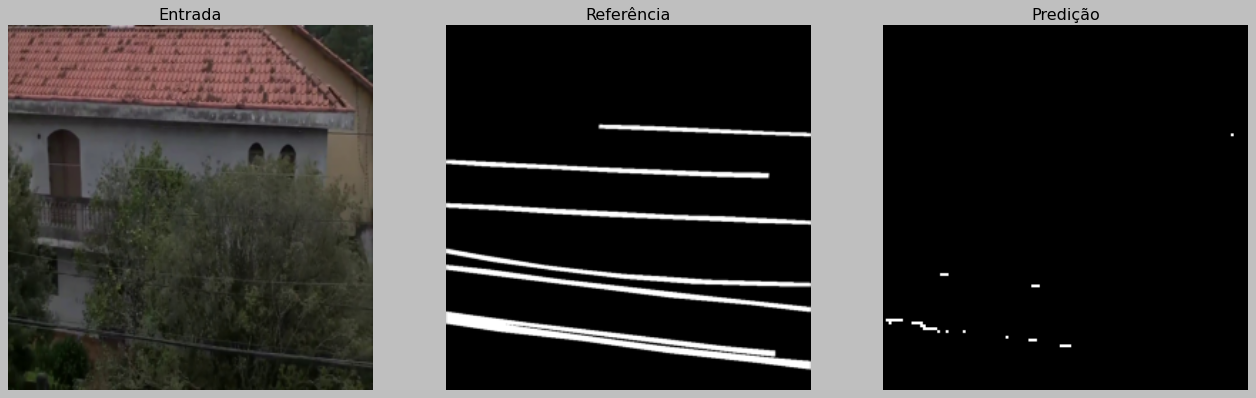

In [ ]:
# predição dados treino
plot_sample(X_original, y_train, preds_train, preds_train_t)

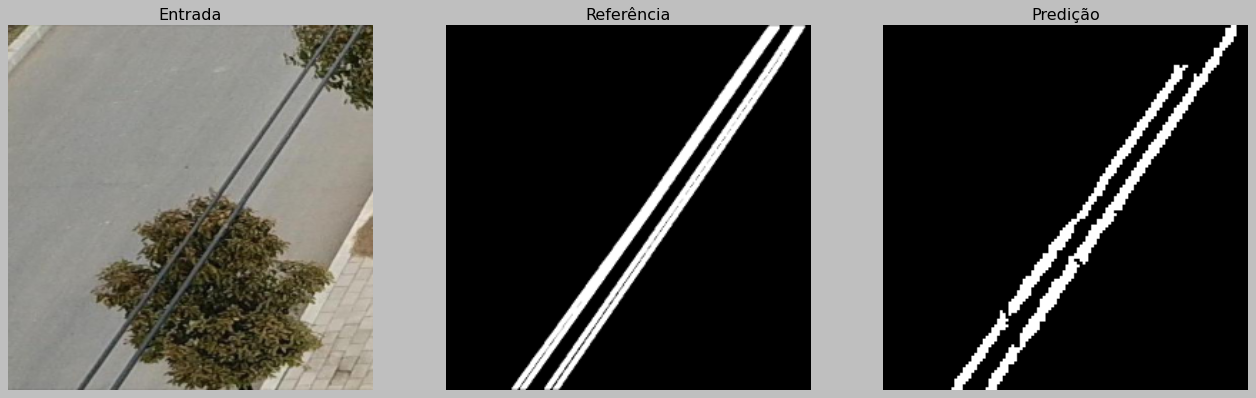

In [ ]:
# predição dados validação
plot_sample(X_valid_original, y_valid, preds_val, preds_val_t, ix=19)

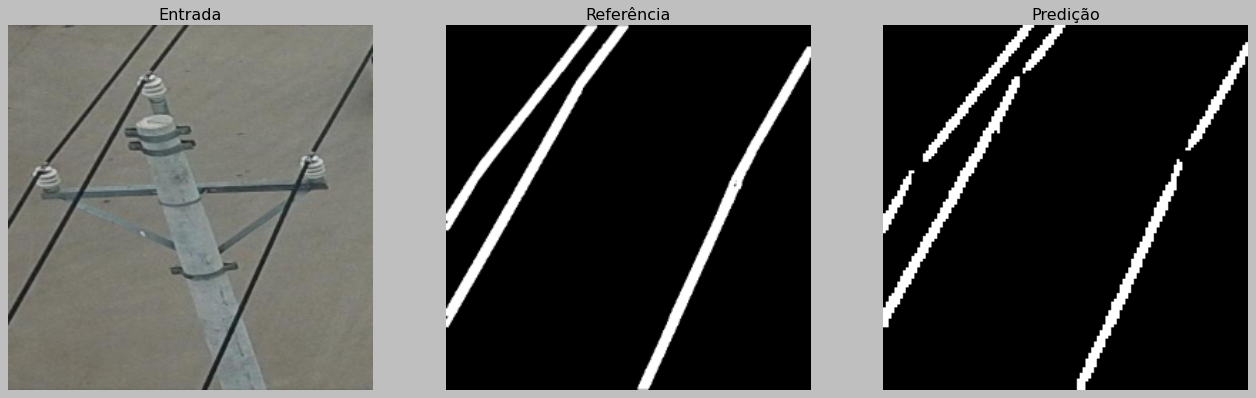

In [ ]:
plot_sample(X_valid_original, y_valid, preds_val, preds_val_t)

In [ ]:
dice_coef = dice_coef(y_valid, preds_val)
print(dice_coef)
iou = iou(y_valid, preds_val)
print(iou)


tf.Tensor(0.14482722, shape=(), dtype=float32)
tf.Tensor(0.07806659, shape=(), dtype=float32)


In [ ]:
## ainda não foi testado




Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.7909
Epoch 1: val_loss improved from inf to 0.13873, saving model to VGG16_UNet.h5
129/129 [==============================] - 95s 689ms/step - loss: 0.3876 - accuracy: 0.7909 - val_loss: 0.1387 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 2/20
129/129 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.8035
Epoch 2: val_loss did not improve from 0.13873
129/129 [==============================] - 87s 675ms/step - loss: 0.1946 - accuracy: 0.8035 - val_loss: 0.1633 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 3/20
129/129 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.8055
Epoch 3: val_loss improved from 0.13873 to 0.13215, saving model to VGG16_UNet.h5
129/129 [==============================] - 91s 708ms/step - loss: 0.1775 - accuracy: 0.8055 - val_loss: 0.1321 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 4/20
129/129 [==============================] - ETA: 0s - 

Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.8029
Epoch 1: val_loss improved from inf to 0.15558, saving model to MobileNetV2_UNet.h5
129/129 [==============================] - 55s 218ms/step - loss: 0.2769 - accuracy: 0.8029 - val_loss: 0.1556 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 2/20
129/129 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.8092
Epoch 2: val_loss did not improve from 0.15558
129/129 [==============================] - 26s 205ms/step - loss: 0.1323 - accuracy: 0.8092 - val_loss: 0.1984 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 3/20
129/129 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.8108
Epoch 3: val_loss did not improve from 0.15558
129/129 [==============================] - 26s 201ms/step - loss: 0.1209 - accuracy: 0.8108 - val_loss: 0.2011 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 4/20
129/129 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.81

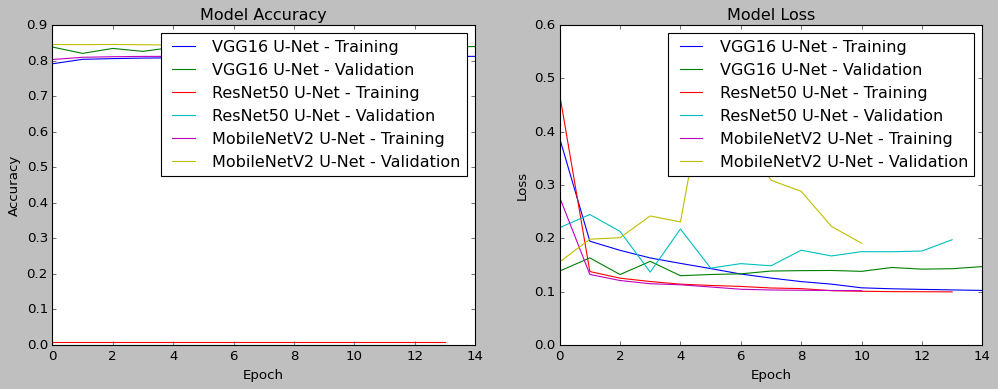

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, TensorBoard

# Carregar seus dados (X_train, y_train)
# ...

# Função para criar e treinar modelos
def train_model(model, model_name):
    callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
        ModelCheckpoint(f'{model_name}.h5', verbose=1, save_best_only=True, save_weights_only=False),
        CSVLogger(f"data-{model_name}.csv"),
        TensorBoard(log_dir=f'./logs/{model_name}')
    ]

    history = model.fit(X_train, y_train,
                        batch_size=12,
                        epochs=20,
                        verbose=1,
                        validation_split=0.2,
                        shuffle=True,
                        callbacks=callbacks)
    return history

input_img = Input((im_height, im_width, 1), name='img')
unet_adaptada = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
unet_adaptada_history = train_model(unet_adaptada, 'UNet_Adaptada')

# Criar e treinar o modelo VGG16 U-Net
vgg16_unet = build_unet_vgg16(input_shape, num_classes)
vgg16_unet_history = train_model(vgg16_unet, 'VGG16_UNet')

# Criar e treinar o modelo ResNet50 U-Net
resnet50_unet = build_unet_resnet50(input_shape, num_classes)
resnet50_unet_history = train_model(resnet50_unet, 'ResNet50_UNet')

# Criar e treinar o modelo MobileNetV2 U-Net
mobilenetv2_unet = build_unet_mobilenetv2(input_shape, num_classes)
mobilenetv2_unet_history = train_model(mobilenetv2_unet, 'MobileNetV2_UNet')





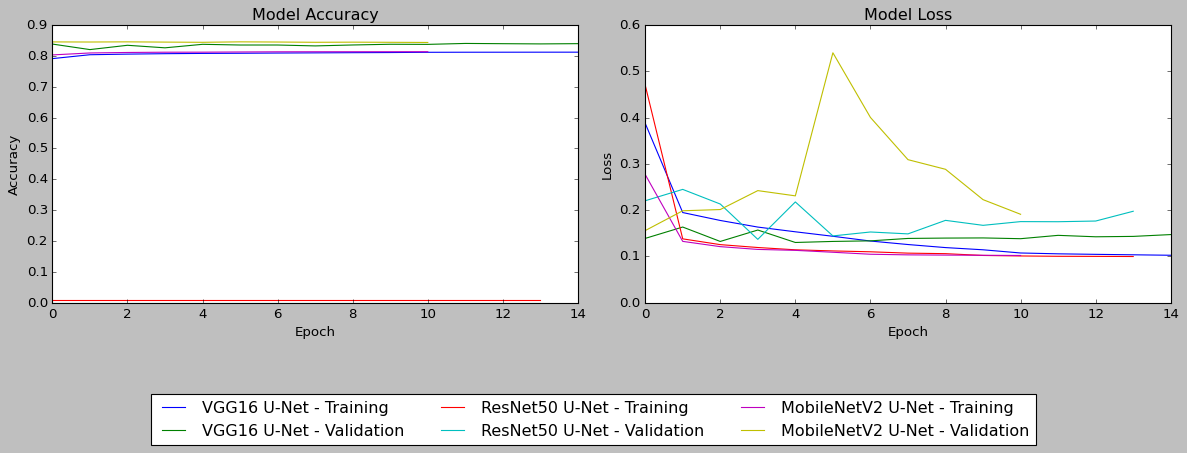

In [ ]:
def plot_history(histories, titles):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for history, title in zip(histories, titles):
        # Gráfico de Acurácia
        axs[0].plot(history.history['accuracy'], label=f"{title} - Training")
        axs[0].plot(history.history['val_accuracy'], label=f"{title} - Validation")
        axs[0].set_title('Model Accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')

        # Gráfico de Perda
        axs[1].plot(history.history['loss'], label=f"{title} - Training")
        axs[1].plot(history.history['val_loss'], label=f"{title} - Validation")
        axs[1].set_title('Model Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')

    # Adicionando a legenda abaixo dos gráficos
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(histories), bbox_to_anchor=(0.5, -0.15))

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

plot_history([vgg16_unet_history, resnet50_unet_history, mobilenetv2_unet_history], ['VGG16 U-Net', 'ResNet50 U-Net','MobileNetV2 U-Net'])


In [ ]:
import pandas as pd
import numpy as np

def save_history_to_csv(histories, titles, filename):
    data = {}

    max_length = max([len(history.history['accuracy']) for history in histories])

    for history, title in zip(histories, titles):
        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']

        # Preenchendo os dados ausentes com NaN
        training_accuracy += [np.nan] * (max_length - len(training_accuracy))
        validation_accuracy += [np.nan] * (max_length - len(validation_accuracy))
        training_loss += [np.nan] * (max_length - len(training_loss))
        validation_loss += [np.nan] * (max_length - len(validation_loss))

        data[f"{title} - Training Accuracy"] = training_accuracy
        data[f"{title} - Validation Accuracy"] = validation_accuracy
        data[f"{title} - Training Loss"] = training_loss
        data[f"{title} - Validation Loss"] = validation_loss

    df = pd.DataFrame(data)
    df.to_csv(filename, index_label='Epoch')

save_history_to_csv([vgg16_unet_history, resnet50_unet_history, mobilenetv2_unet_history],
                    ['VGG16 U-Net', 'ResNet50 U-Net', 'MobileNetV2 U-Net'],
                    'unet_results.csv')
